In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
problem = 'Animals'
train = pd.read_csv('data/' + problem + '/train.csv')
#train.head()

# Visualizing and preprocessing the data

### Drop useless features

In [3]:
train.drop(['OutcomeSubtype', 'AnimalID'], axis=1, inplace=True)

### Explore the data a little...

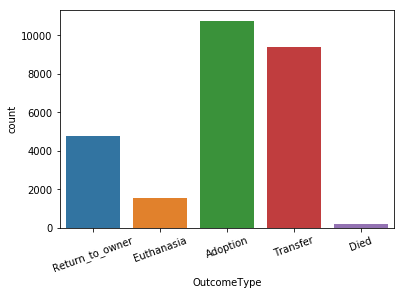

In [4]:
ax = sns.countplot(train.OutcomeType)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()

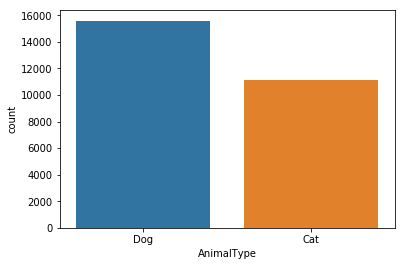

In [5]:
sns.countplot(train.AnimalType)

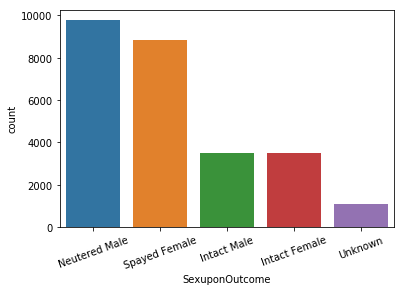

In [6]:
ax = sns.countplot(train.SexuponOutcome)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()

### Generate new features from existing ones

In [7]:
def process_name(df):
    df['HasName'] = 1
    df.loc[df.Name.isnull(), 'HasName'] = 0

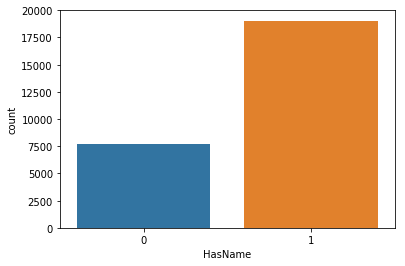

In [8]:
process_name(train)
sns.countplot(train.HasName)

In [9]:
def process_sex(x):
    x = str(x)
    if 'Male' in x:
        return 'Male'
    elif 'Female' in x:
        return 'Female'
    return 'Unknown'
    
def process_sterilization(x):
    x = str(x)
    if ('Spayed' in x) or ('Neutered' in x):
        return 'Sterilized'
    elif 'Intact' in x:
        return 'Intact'
    return 'Unknown'

In [10]:
train['Sex'] = train.SexuponOutcome.apply(process_sex)
train['Sterilized'] = train.SexuponOutcome.apply(process_sterilization)

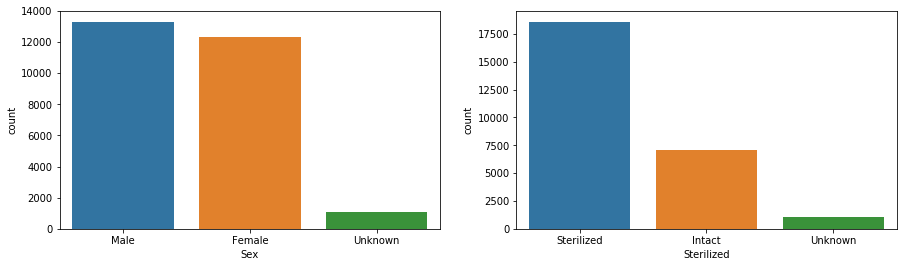

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(train.Sex, ax=ax1)
sns.countplot(train.Sterilized, ax=ax2)

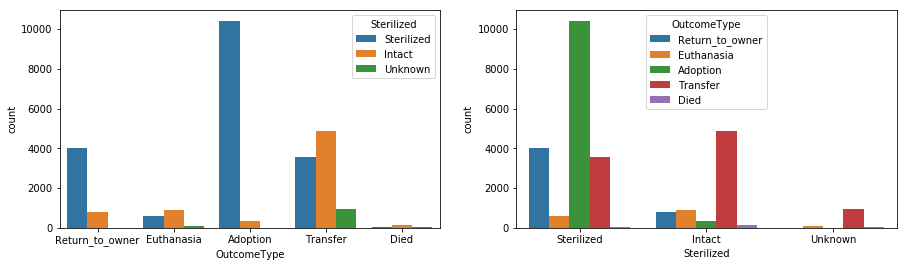

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(data=train, x='OutcomeType', hue='Sterilized', ax=ax1)
sns.countplot(data=train, x='Sterilized', hue='OutcomeType', ax=ax2)

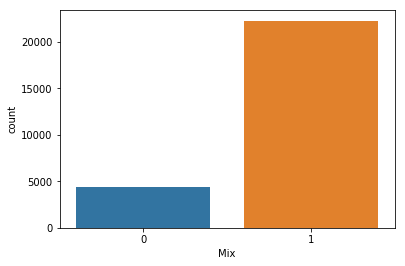

In [13]:
train['Mix'] = train.Breed.apply(lambda x: int(str(x).endswith('Mix')))
train['Breed'] = train.Breed.str.rstrip(' Mix')
sns.countplot(train.Mix)

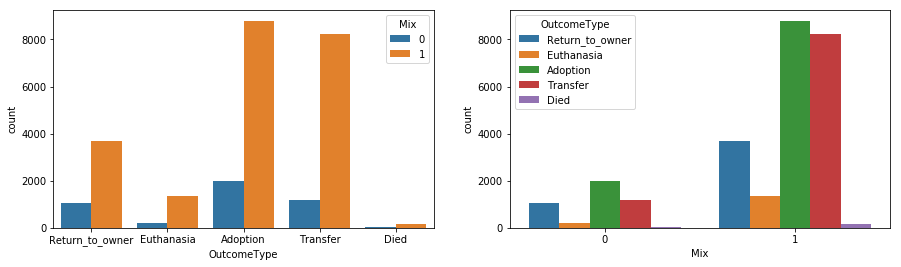

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(data=train, x='OutcomeType', hue='Mix', ax=ax1)
sns.countplot(data=train, x='Mix', hue='OutcomeType', ax=ax2)

In [15]:
def process_age(age):
    days_in_unit = {
        'day': 1,
        'days': 1,
        'week': 7,
        'weeks': 7,
        'month': 30,
        'months': 30,
        'years': 365,
        'year': 365
    }

    if not isinstance(age, str): return float('nan')
    age = age.split(' ')
    return int(age[0]) * days_in_unit[age[1]]

train['Age'] = train['AgeuponOutcome'].map(process_age) # / 365

Impute mean/median values intead of NaNs

In [16]:
def impute_age(src, dst):
    for f, g in dst.loc[dst['Age'].isnull()].groupby(['Breed', 'Mix', 'Sex']):
        gtrain = src.loc[
                (src['Breed'] == f[0]) &
                (src['Mix'] == f[1]) &
                ( (src['Sex'] == f[2]) ), # if f[2] else True ),
            'Age']
        med, cnt = gtrain.median(), gtrain.count()
        if cnt < 30: med = gtrain.mean()
        dst.loc[dst['Age'].isnull() &
             (dst['Breed'] == f[0]) &
             (dst['Mix'] == f[1]) &
             (dst['Sex'] == f[2]),
                'Age'] = med
        #print('Imputed age %s from %s samples of %s %s %s' % (
        #      med, cnt,
        #      f[0],
        #     'Mix' if f[1] else '',
        #     'Male' if f[2] == 0 else ('Female' if f[2] == 1 else 'Bisexual')))

In [17]:
impute_age(train, train)

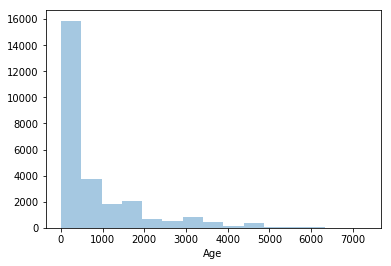

In [18]:
sns.distplot(train.Age, bins = 15, kde=False)

In [19]:
def get_age_category(x):
    if x < 0.84: return 'Newborn'
    if x < 1: return 'Child'
    if x < 6: return 'Teen'
    if x < 11: return 'Adult'
    return 'Old'
train['AgeCategory'] = train.Age.apply(get_age_category)
train['YoungAge'] = train.Age.apply(lambda x: int(x < 3))

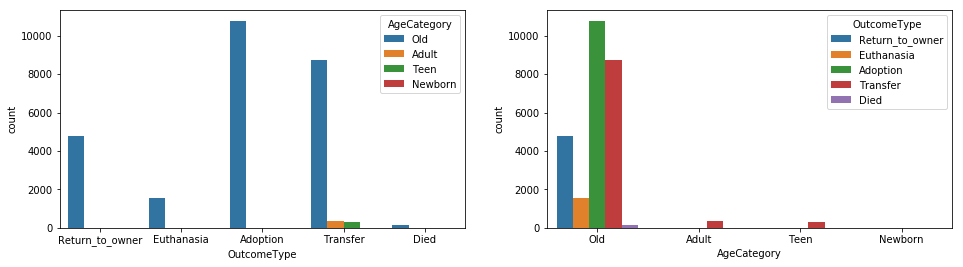

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='AgeCategory', ax=ax1)
sns.countplot(data=train, x='AgeCategory',hue='OutcomeType', ax=ax2)

In [21]:
def hour_to_time_of_day(h):
    if h >= 5 and h < 11:
        return 'Morning'
    elif h >= 11 and h < 16:
        return 'Midday'
    elif h >= 16 and h < 20:
        return 'Evening'
    return 'Night'

In [22]:
import dateutil

def process_date(df):
    df['Year'] = df.DateTime.apply(lambda x: dateutil.parser.parse(x).year)
    df['Month'] = df.DateTime.apply(lambda x: dateutil.parser.parse(x).month)
    df['Day'] = df.DateTime.apply(lambda x: dateutil.parser.parse(x).day)
    df['Hour'] = df.DateTime.apply(lambda x: dateutil.parser.parse(x).hour)
    df['Weekday'] = df.DateTime.apply(lambda x: dateutil.parser.parse(x).weekday())
    df['TimeOfDay'] = df.Hour.apply(hour_to_time_of_day)

In [23]:
process_date(train)

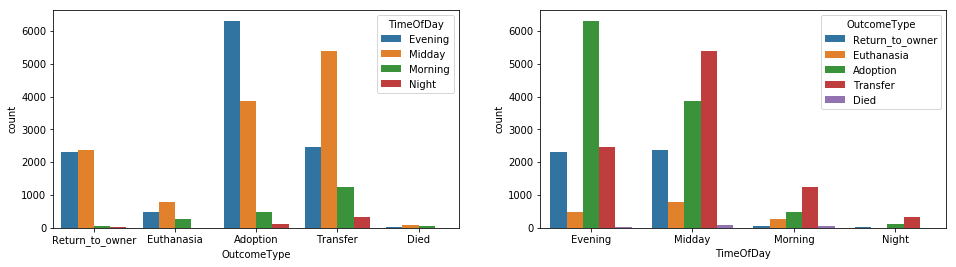

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='TimeOfDay', ax=ax1)
sns.countplot(data=train, x='TimeOfDay',hue='OutcomeType', ax=ax2)

In [25]:
import re
train['SimpleColor'] = train.Color.apply(lambda x: re.split('/| ', x)[0])

In [26]:
train['SimpleBreed'] = train.Breed.apply(lambda x: re.split('/', x)[0])
popular_breed = train.SimpleBreed.value_counts()[0:25].index.tolist()
train.SimpleBreed = train.SimpleBreed.apply(lambda x: x if x in popular_breed else 'Rare')

In [57]:
features = ['AnimalType', 'HasName', 'Sterilized',\
       'Age', 'Month', 'Day', 'Hour',\
       'Weekday', 'SimpleColor', 'SimpleBreed'] #  'Year', 'Sex', , 'TimeOfDay', 'AgeCategory'

X = train[features].copy()
y = train['OutcomeType'].copy()

In [58]:
from sklearn.preprocessing import LabelEncoder

encoded = ['AnimalType', 'Sterilized',\
           'SimpleColor', 'SimpleBreed'] #'Sex', 'TimeOfDay', 'AgeCategory', 
encoders = {}

for col in encoded:
    e = LabelEncoder()
    encoders[col] = e
    X[col] = e.fit_transform(X[col])

y = LabelEncoder().fit_transform(y)

In [54]:
X.head()

,AnimalType,HasName,Sterilized,Age,Month,Day,Hour,Weekday,SimpleColor,SimpleBreed
0,1,1,1,365.0,2,12,18,2,4,19
1,0,1,1,365.0,10,13,12,6,8,12
2,1,1,1,730.0,1,31,12,5,3,18
3,0,0,0,21.0,7,11,19,4,3,12
4,1,0,1,730.0,11,15,12,4,23,19


# Training

In [29]:
# fix random seed for reproducibility
import numpy as np
seed = 7
np.random.seed(seed)

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=seed)

## Logistic Regression

In [32]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

degree = 2

logfit = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree)), 
    ('clf', LogisticRegression())])

scores = cross_val_score(logfit, X, y, scoring='neg_log_loss')
print('score: %s' % -scores.mean())

score: 0.861686484339


In [33]:
logfit.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly_features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

## KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier

params = { 
    'n_neighbors': [x for x in range(98, 120, 2)],
    #'weights': ['uniform', 'distance'],
    #'p': [1, 2, 3],
}

knn = GridSearchCV(KNeighborsClassifier(), 
                   param_grid=params, 
                   scoring='neg_log_loss',
                   verbose=1, n_jobs=8)

knn.fit(X_train, y_train);

print('Best params for knn: ', knn.best_params_)
print('Best score: ', -knn.best_score_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
Best params for knn:  {'n_neighbors': 116}
Best score:  1.14063017947


[Parallel(n_jobs=8)]: Done  33 out of  33 | elapsed:   30.9s finished


Best params for knn:  {'n_neighbors': 98, 'p': 2}
Best score:  1.16468466241

## Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [800], # , , 120 500, 300, 800
    'max_depth': [15], # , 5, 8, , None 30,, 25
    'min_samples_split': [5], # , 10, 100 15, 2, 
    'min_samples_leaf': [2], # ,10,1 , 5
    'max_features': ['log2'] #, None 'sqrt',
}

forest = GridSearchCV(RandomForestClassifier(), 
                      param_grid=params, 
                      scoring='neg_log_loss', 
                      verbose=10, n_jobs=8)
forest.fit(X, y);

print('Best params: ', forest.best_params_)
print('Best score: ', -forest.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=800 
[CV] max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=800 
[CV] max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=800 
[CV]  max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=800, score=-0.759026, total=  24.1s
[CV]  max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=800, score=-0.770317, total=  24.1s
[CV]  max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=800, score=-0.773550, total=  24.2s


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   33.2s finished


Best params:  {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 800}
Best score:  0.767632274237


Best params:  {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1200}
Best score:  0.766169923256

Feature ranking:
1. Age (0.225484)
2. Sterilized (0.202088)
3. Hour (0.136778)
4. Day (0.082264)
5. HasName (0.081200)
6. Month (0.063948)
7. Weekday (0.062352)
8. SimpleBreed (0.060207)
9. SimpleColor (0.050511)
10. AnimalType (0.035167)


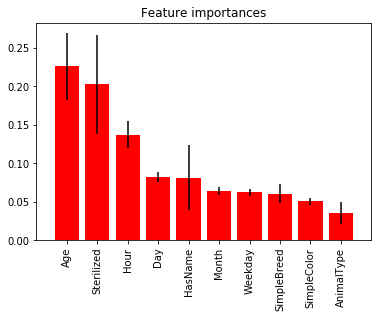

In [44]:
importances = forest.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
mapper = np.vectorize(lambda x: features[x])
plt.xticks(range(X.shape[1]), mapper(indices), rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## NN

In [45]:
from keras.utils import np_utils
dummy_y = np_utils.to_categorical(y)

Using TensorFlow backend.


In [46]:
import keras
from keras.models import Sequential
from keras.layers import Dense

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(dummy_y.shape[1], activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [47]:
from keras.wrappers.scikit_learn import KerasClassifier
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [48]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [49]:
#results = cross_val_score(estimator, X, dummy_y, cv=kfold)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

X_scaler = StandardScaler()
estimator.fit(np.array(X_scaler.fit_transform(X)), dummy_y)

Epoch 1/10
26729/26729 [==============================] - 13s - loss: 1.0326 - acc: 0.5832    
Epoch 2/10
26729/26729 [==============================] - 13s - loss: 0.9071 - acc: 0.6284    
Epoch 3/10
26729/26729 [==============================] - 13s - loss: 0.8954 - acc: 0.6343    
Epoch 4/10
26729/26729 [==============================] - 14s - loss: 0.8836 - acc: 0.6414    
Epoch 5/10
26729/26729 [==============================] - 14s - loss: 0.8734 - acc: 0.6455    
Epoch 6/10
26729/26729 [==============================] - 14s - loss: 0.8663 - acc: 0.6494    
Epoch 7/10
26729/26729 [==============================] - 15s - loss: 0.8627 - acc: 0.6508    
Epoch 8/10
26729/26729 [==============================] - 14s - loss: 0.8597 - acc: 0.6509    
Epoch 9/10
26729/26729 [==============================] - 13s - loss: 0.8573 - acc: 0.6517    
Epoch 10/10
26729/26729 [==============================] - 13s - loss: 0.8562 - acc: 0.6545    


# Submit to Kaggle

In [59]:
test = pd.read_csv('data/' + problem + '/test.csv')
process_name(test)
test['Sex'] = test.SexuponOutcome.apply(process_sex)
test['Sterilized'] = test.SexuponOutcome.apply(process_sterilization)
test['Mix'] = test.Breed.apply(lambda x: int(str(x).endswith('Mix')))
test['Breed'] = test.Breed.str.rstrip(' Mix')
test['Age'] = test['AgeuponOutcome'].map(process_age) / 365
impute_age(train, test)
test['AgeCategory'] = test.Age.apply(get_age_category)
test['YoungAge'] = test.Age.apply(lambda x: int(x < 3))
process_date(test)
test['SimpleColor'] = test.Color.apply(lambda x: re.split('/| ', x)[0])
test['SimpleBreed'] = test.Breed.apply(lambda x: re.split('/', x)[0])
test.SimpleBreed = test.SimpleBreed.apply(lambda x: x if x in popular_breed else 'Rare')

X_test = test[features].copy()

for col in encoded:
    X_test[col] = encoders[col].transform(X_test[col])

In [51]:
from sklearn.preprocessing import label_binarize

def submit(clf, name, X):
    predicts = clf.predict_proba(X)
    ids = test.ID
    
    answers = pd.DataFrame(predicts)
    answers = pd.concat([ids, answers], axis=1)
    answers.columns = ['ID', 'Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
    answers.to_csv(name + '.csv', index=False)

In [52]:
submit(forest, 'forest', X_test)

In [53]:
submit(estimator, 'nn', np.array(X_test))

11250/11456 [============================>.] - ETA: 0s